#  IA para Redes de Suministro 

üë§ **Autor:** John Leonardo Vargas Mesa  
üîó [LinkedIn](https://www.linkedin.com/in/leonardovargas/) | [GitHub](https://github.com/LeStark)  

## üìÇ Repositorio en GitHub  
- üìì **Notebooks:** [Acceder aqu√≠](https://github.com/LeStark/Cursos/tree/main/02%20-%20IA4SC)  
- üìë **Data sets:** [Acceder aqu√≠](https://github.com/LeStark/Cursos/tree/main/00%20-%20Data/02%20-%20SC)  
---

# üìó Notebook 6 ‚Äì Uso de algoritmos de *Machine Learning* para la predicci√≥n de demanda

Este notebook desarrolla un proceso completo de **predicci√≥n de demanda semanal** utilizando algoritmos de *Machine Learning* aplicados a series temporales.  
El objetivo es mostrar c√≥mo transformar datos hist√≥ricos de ventas en un conjunto de entrenamiento adecuado para modelos predictivos capaces de anticipar la demanda futura por tienda y producto.

## üß© **Contenido del Notebook**

1. **Exploraci√≥n y An√°lisis de Datos (EDA):**  
   Se inicia con la carga y revisi√≥n de un dataset de ventas hist√≥ricas que contiene las columnas `date`, `store`, `item` y `sales`.  
   Se realizan an√°lisis exploratorios para comprender el rango temporal, la distribuci√≥n de ventas y el n√∫mero de tiendas y productos.

2. **Conversi√≥n a Series Semanales:**  
   Los datos diarios se agrupan por semana mediante `resample('W')`, manteniendo la desagregaci√≥n por tienda y producto.  
   Se a√±aden las columnas `year` y `week` para estructurar temporalmente la informaci√≥n.

3. **Descomposici√≥n de la Serie Temporal:**  
   Se analiza la estructura interna de la demanda separando componentes de tendencia y estacionalidad mediante `seasonal_decompose`.  
   Esto permite identificar patrones de crecimiento o fluctuaci√≥n a lo largo del tiempo.

4. **Creaci√≥n de Variables Temporales C√≠clicas:**  
   Se generan variables `sin_week` y `cos_week` para representar el car√°cter **peri√≥dico** de las semanas del a√±o.  
   Estas variables ayudan al modelo a captar la naturaleza c√≠clica del tiempo sin rupturas entre la semana 52 y la semana 1.

5. **Ingenier√≠a de Caracter√≠sticas (Feature Engineering):**  
   - **Rezagos (lags):** se crean variables como `sales_lag_1`, `sales_lag_2`, `sales_lag_4`, `sales_lag_8`, `sales_lag_12` que representan ventas pasadas.  
   - **Ventanas m√≥viles (rolling):** se calculan medias y desviaciones est√°ndar sobre 4 y 8 semanas (`rolling_mean_4`, `rolling_std_8`) para capturar tendencias locales.

6. **Divisi√≥n Temporal de Datos:**  
   En lugar de un `train_test_split` aleatorio, se separan los datos **por a√±o**, entrenando con el hist√≥rico (hasta 2016) y evaluando con 2017, para preservar la secuencia temporal.

7. **Comparaci√≥n de Modelos de Regresi√≥n:**  
   Se entrenan y comparan distintos modelos:
   - **Regresi√≥n Lineal**  
   - **Random Forest**  
   - **Gradient Boosting**  
   - **XGBoost**  
   Se eval√∫an mediante **RMSE** y **R¬≤**, identificando cu√°l logra la mejor capacidad predictiva.

8. **Predicci√≥n Recursiva de la Demanda 2018:**  
   Se genera un conjunto base para el a√±o 2018 con todas las combinaciones de tienda‚Äìproducto‚Äìsemana, y se aplican las predicciones semana a semana.  
   Tras cada predicci√≥n, se recalculan las variables de rezago para incorporar la informaci√≥n m√°s reciente (*forecasting recursivo*).

9. **Visualizaci√≥n de Resultados:**  
   Se grafican las ventas hist√≥ricas y las predicciones, diferenciando los periodos observados y pronosticados (por ejemplo, 2018 en color rojo).  
   Tambi√©n se incluye una versi√≥n interactiva para explorar el pron√≥stico por tienda y producto.

## üéØ **Objetivo de Aprendizaje**

Al finalizar el notebook, el estudiante ser√° capaz de:
- Comprender la naturaleza temporal y dependiente de los datos de demanda.  
- Aplicar ingenier√≠a de caracter√≠sticas que preserve la secuencia temporal.  
- Entrenar y comparar modelos de regresi√≥n sobre series temporales.  
- Implementar un esquema de pron√≥stico autoregresivo para proyectar periodos futuros.


## üßæ **Herramientas Utilizadas**
- **Python / Pandas / NumPy:** manejo y transformaci√≥n de datos  
- **Matplotlib / Seaborn:** an√°lisis visual  
- **scikit-learn:** modelado, evaluaci√≥n y m√©tricas  
- **XGBoost:** modelo avanzado de boosting  
- **statsmodels:** descomposici√≥n de series temporales  

*Este notebook sirve como introducci√≥n pr√°ctica al uso de modelos de Machine Learning en series temporales de demanda, mostrando c√≥mo combinar t√©cnicas estad√≠sticas, ingenier√≠a de variables y modelos predictivos para anticipar el comportamiento futuro de ventas.*


In [1]:
# ===============================================
#  Importaci√≥n de librer√≠as
# ===============================================
# --- Librer√≠as b√°sicas ---
import numpy as np
import pandas as pd

# --- Visualizaci√≥n ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modelado y evaluaci√≥n ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

##  Descripci√≥n de la Celda de Datos

Esta tabla representa un conjunto de datos de ventas diarias en una tienda espec√≠fica. Cada fila corresponde a una transacci√≥n registrada en un d√≠a determinado.

### Columnas

- **date**: Fecha de la transacci√≥n en formato `YYYY-MM-DD`.
- **store**: Identificador de la tienda. En este caso, todas las transacciones provienen de la tienda `1`.
- **item**: Identificador del producto vendido. Aqu√≠, todas las filas corresponden al producto `1`.
- **sales**: N√∫mero de unidades vendidas en ese d√≠a.

### Datos Registrados

| date       | store | item | sales |
|------------|-------|------|-------|
| 2013-01-01 | 1     | 1    | 13    |
| 2013-01-02 | 1     | 1    | 11    |
| 2013-01-03 | 1     | 1    | 14    |
| 2013-01-04 | 1     | 1    | 13    |
| 2013-01-05 | 1     | 1    | 10    |

### Observaciones

- El producto `1` fue vendido exclusivamente en la tienda `1` durante los primeros cinco d√≠as de enero de 2013.
- Las ventas fluct√∫an ligeramente entre los d√≠as, con un m√°ximo de `14` unidades el 3 de enero y un m√≠nimo de `10` el 5 de enero.

Este tipo de datos es √∫til para an√°lisis de tendencias de ventas, predicci√≥n de demanda, y evaluaci√≥n del rendimiento de productos o tiendas.

In [2]:
url_train = "https://raw.githubusercontent.com/LeStark/Cursos/refs/heads/main/00%20-%20Data/02%20-%20SC/Demand%20forecasting/train.csv"
data = pd.read_csv(url_train)
data.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
# Valores √∫nicos en cada columna
stores_unicos = data['store'].unique()
items_unicos = data['item'].unique()

print(f" Tiendas √∫nicas: {len(stores_unicos)} ‚Üí {stores_unicos[:10]}")  # [:10] muestra solo los primeros 10
print(f" Productos √∫nicos: {len(items_unicos)} ‚Üí {items_unicos[:10]}")

 Tiendas √∫nicas: 10 ‚Üí [ 1  2  3  4  5  6  7  8  9 10]
 Productos √∫nicos: 50 ‚Üí [ 1  2  3  4  5  6  7  8  9 10]


In [5]:
# Valores √∫nicos de la columna 'date'
fechas_unicas = data['date'].unique()

print(f"üìÜ Total de fechas √∫nicas: {len(fechas_unicas)}")
print(f"Primera fecha: {min(fechas_unicas)}")
print(f"√öltima fecha: {max(fechas_unicas)}")

üìÜ Total de fechas √∫nicas: 1826
Primera fecha: 2013-01-01
√öltima fecha: 2017-12-31


### Agrupaci√≥n semanal por tienda y producto

En esta celda se transforma la columna `date` a formato de fecha (`datetime`) y luego se realiza una **agrupaci√≥n semanal** de las ventas (`sales`) por combinaci√≥n de **tienda (`store`)** y **producto (`item`)**.  
El m√©todo `resample('W')` permite consolidar las ventas diarias en ventas **totales por semana**, sumando los valores dentro de cada periodo.  
Finalmente, se agregan las columnas de **a√±o (`year`)** y **semana ISO (`week`)** para facilitar an√°lisis temporales y modelado posterior.


In [6]:
# Asegurar formato datetime
data['date'] = pd.to_datetime(data['date'])

# Agrupar por tienda y producto con resample semanal
data_semanal = (
    data
    .set_index('date')
    .groupby(['store', 'item'])
    .resample('W')['sales']
    .sum()
    .reset_index()
)

# Agregar columnas de a√±o y n√∫mero de semana ISO
data_semanal['year'] = data_semanal['date'].dt.isocalendar().year
data_semanal['week'] = data_semanal['date'].dt.isocalendar().week

# Mostrar resultado
data_semanal.head()

store  item       date  sales  year  week
0      1     1 2013-01-06     73  2013     1
1      1     1 2013-01-13     66  2013     2
2      1     1 2013-01-20     80  2013     3
3      1     1 2013-01-27     70  2013     4
4      1     1 2013-02-03     86  2013     5

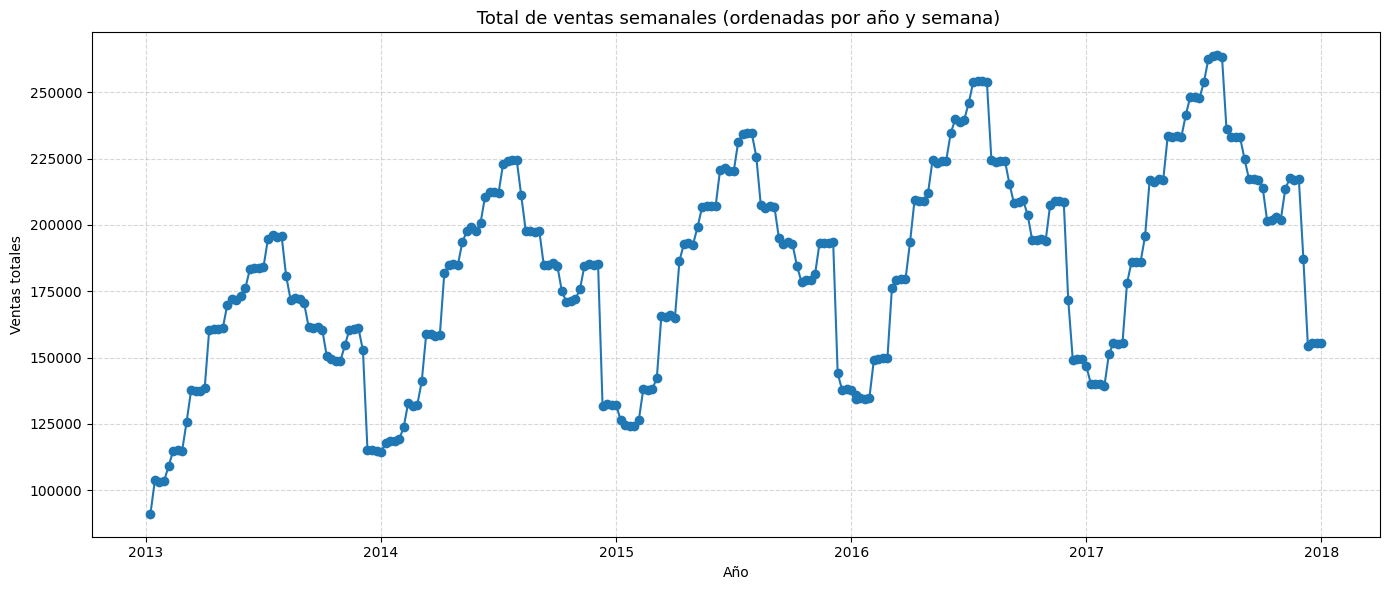

In [7]:

# --- Agrupar las ventas semanales totales ---
ventas_semanales = (
    data_semanal
    .groupby(['year', 'week'])['sales']
    .sum()
    .reset_index()
    .sort_values(['year', 'week'])
)

# --- Crear un eje temporal continuo (a√±o + semana/52) ---
ventas_semanales['x_axis'] = ventas_semanales['year'] + ventas_semanales['week'] / 52

# --- Graficar ---
plt.figure(figsize=(14,6))
plt.plot(
    ventas_semanales['x_axis'],
    ventas_semanales['sales'],
    marker='o',
    linestyle='-'
)
plt.title(" Total de ventas semanales (ordenadas por a√±o y semana)", fontsize=13)
plt.xlabel("A√±o")
plt.ylabel("Ventas totales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

###  Gr√°fico de ventas semanales totales

Esta gr√°fica muestra la evoluci√≥n del **total de ventas semanales** agregadas por a√±o y semana.  
Cada punto representa la suma de las ventas de todas las tiendas y productos en una semana determinada.  
El eje X combina el a√±o con la semana (`year + week/52`) para mostrar la serie temporal de forma continua, mientras que el eje Y indica el volumen total de ventas.  
La visualizaci√≥n permite identificar **patrones estacionales** y **tendencias anuales** en el comportamiento de la demanda, observando los picos y ca√≠das c√≠clicas a lo largo del tiempo.


In [8]:
# Crear las dos particiones
data_historica = data_semanal.copy()

### An√°lisis de la descomposici√≥n temporal de la serie de ventas

En esta celda se realiza un an√°lisis de **series temporales** para entender los componentes que conforman la evoluci√≥n de las ventas totales a lo largo del tiempo:

1. **Agrupaci√≥n semanal:**  
   Se suman las ventas de todas las tiendas y productos por fecha para obtener una **serie hist√≥rica global**.

2. **Definici√≥n del √≠ndice temporal:**  
   La columna `date` se convierte en √≠ndice, lo que permite que la serie se interprete como una secuencia ordenada en el tiempo.

3. **Descomposici√≥n de la serie:**  
   Se aplica el m√©todo `seasonal_decompose` con un modelo aditivo y un periodo de 52 semanas (aproximadamente un a√±o).  
   Esto divide la serie en tres componentes principales:
   - **Tendencia:** direcci√≥n general de crecimiento o decrecimiento.  
   - **Estacionalidad:** patrones repetitivos que se presentan en intervalos regulares (por ejemplo, ciclos anuales).  
   - **Residuo:** variaciones aleatorias no explicadas por los dos componentes anteriores.

4. **Visualizaci√≥n de resultados:**  
   Se grafican los tres componentes para interpretar c√≥mo las ventas cambian con el tiempo, identificar ciclos estacionales y observar la estabilidad o volatilidad del residuo.


c:\Users\jlvar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


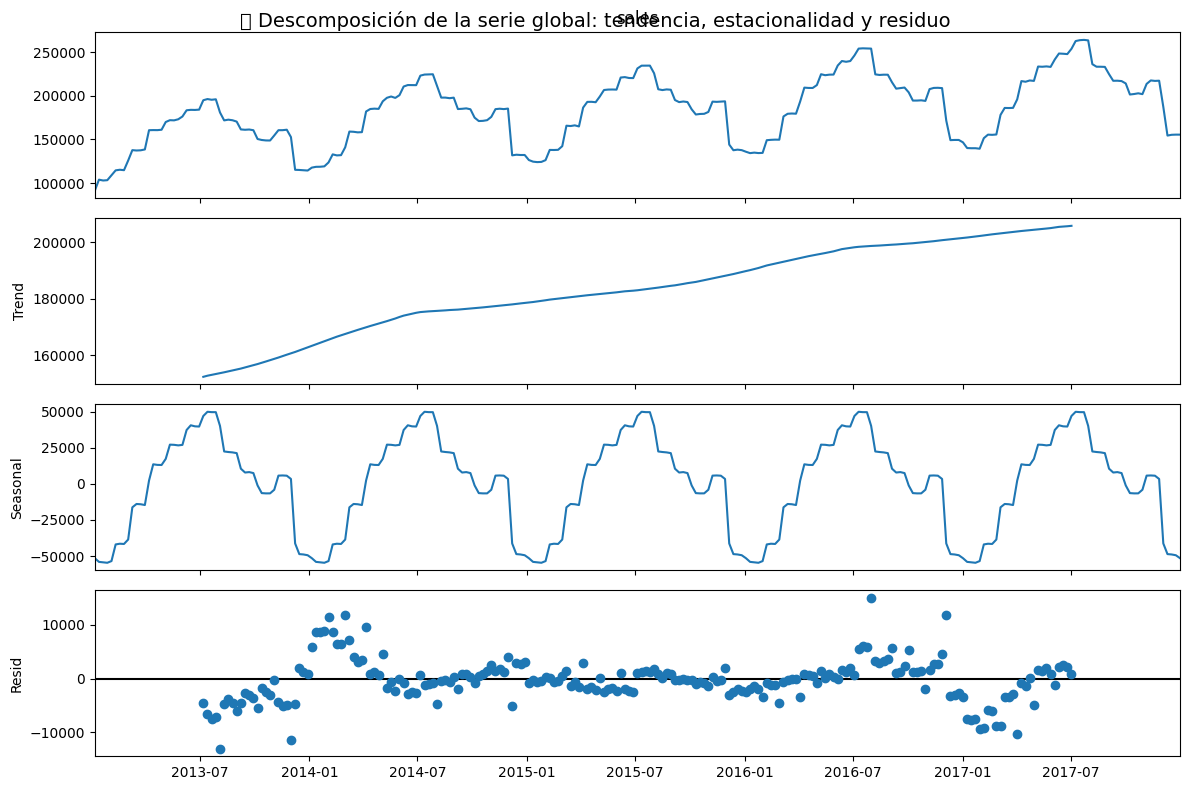

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 1Ô∏è Agrupar ventas semanales totales (todas las tiendas y productos)
serie_historica = (
    data_historica
    .groupby('date')['sales']
    .sum()
    .reset_index()
    .sort_values('date')
)

# 2Ô∏è Establecer el √≠ndice temporal
serie_historica = serie_historica.set_index('date')

# 3Ô∏è Descomponer la serie (modelo aditivo con periodo de 52 semanas ‚âà 1 a√±o)
decompose_result = seasonal_decompose(serie_historica['sales'], model='additive', period=52)

# 4Ô∏è Graficar los componentes
plt.rcParams.update({'figure.figsize': (12,8)})
decompose_result.plot()
plt.suptitle('üìä Descomposici√≥n de la serie global: tendencia, estacionalidad y residuo', fontsize=14)
plt.show()


C:\Users\jlvar\AppData\Local\Temp\ipykernel_28084\2427585169.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\jlvar\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


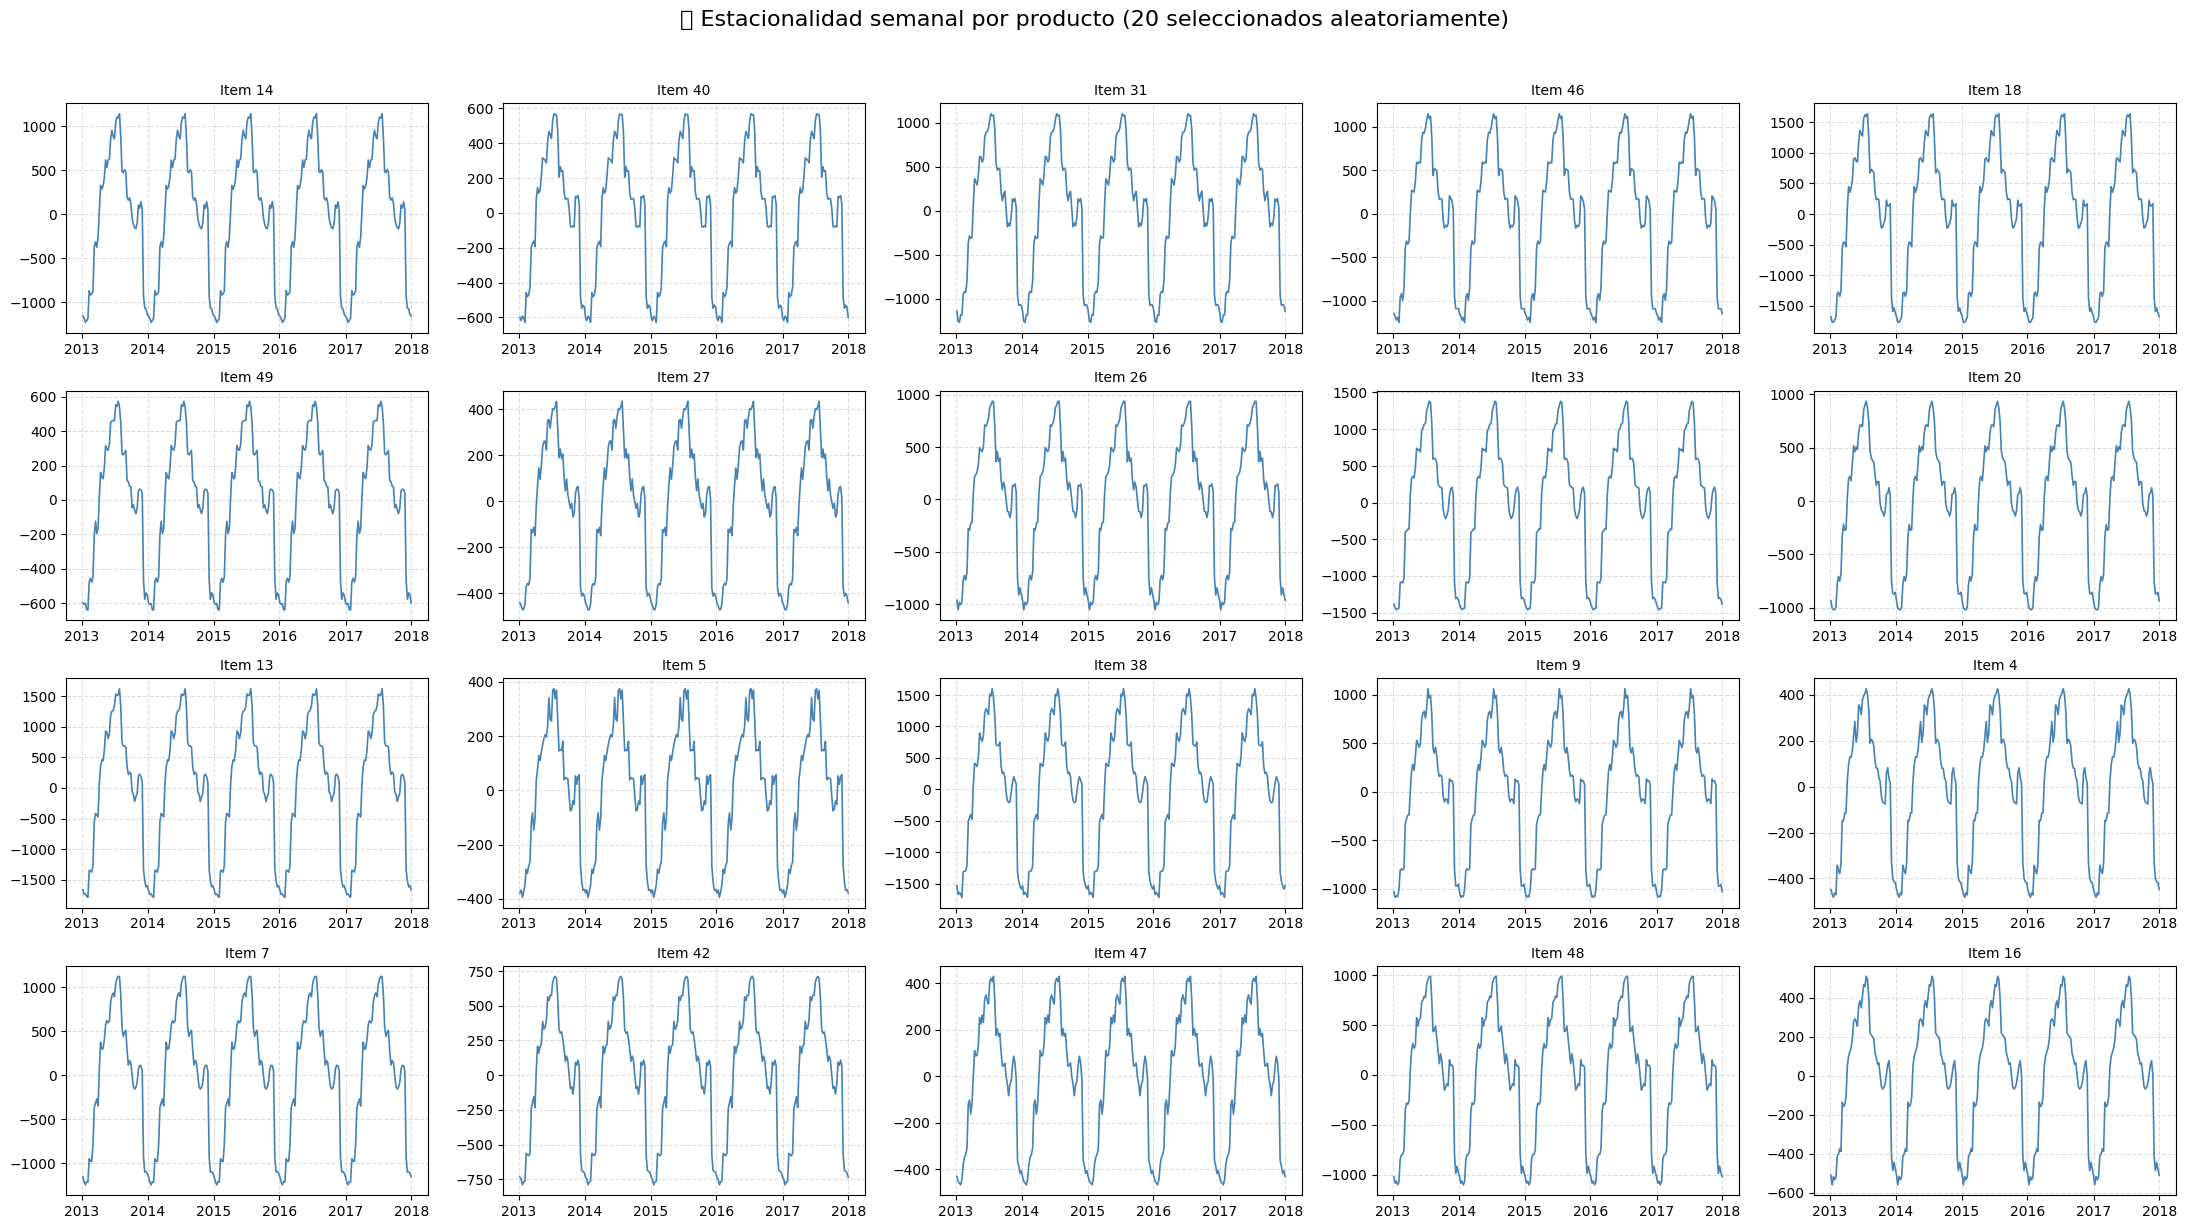

In [10]:
# Seleccionar 20 items aleatorios
np.random.seed(42)  # para reproducibilidad
items = np.random.choice(data_historica['item'].unique(), size=20, replace=False)

# Crear figura 4x5
fig, axes = plt.subplots(4, 5, figsize=(22, 12), sharex=False, sharey=False)
axes = axes.flatten()  # Para iterar f√°cilmente

for idx, i in enumerate(items):
    # Filtrar ventas del producto i (suma de todas las tiendas)
    serie_item = (
        data_historica[data_historica['item'] == i]
        .groupby('date')['sales']
        .sum()
        .reset_index()
        .sort_values('date')
        .set_index('date')
    )

    # Solo descomponer si hay datos suficientes (al menos 2 a√±os)
    if len(serie_item) >= 104:
        decompose_result = seasonal_decompose(serie_item['sales'], model='additive', period=52)
        # Graficar solo el componente estacional
        axes[idx].plot(decompose_result.seasonal, color='steelblue', linewidth=1.2)
        axes[idx].set_title(f'Item {i}', fontsize=10)
        axes[idx].grid(True, linestyle='--', alpha=0.4)
    else:
        axes[idx].text(0.5, 0.5, f'Item {i}\nSin datos suficientes', 
                       ha='center', va='center', fontsize=10, color='red')
        axes[idx].set_axis_off()

# Ocultar los ejes vac√≠os si hay menos de 20 items disponibles
for j in range(len(items), len(axes)):
    axes[j].set_visible(False)

# T√≠tulo general
plt.suptitle('üìä Estacionalidad semanal por producto (20 seleccionados aleatoriamente)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



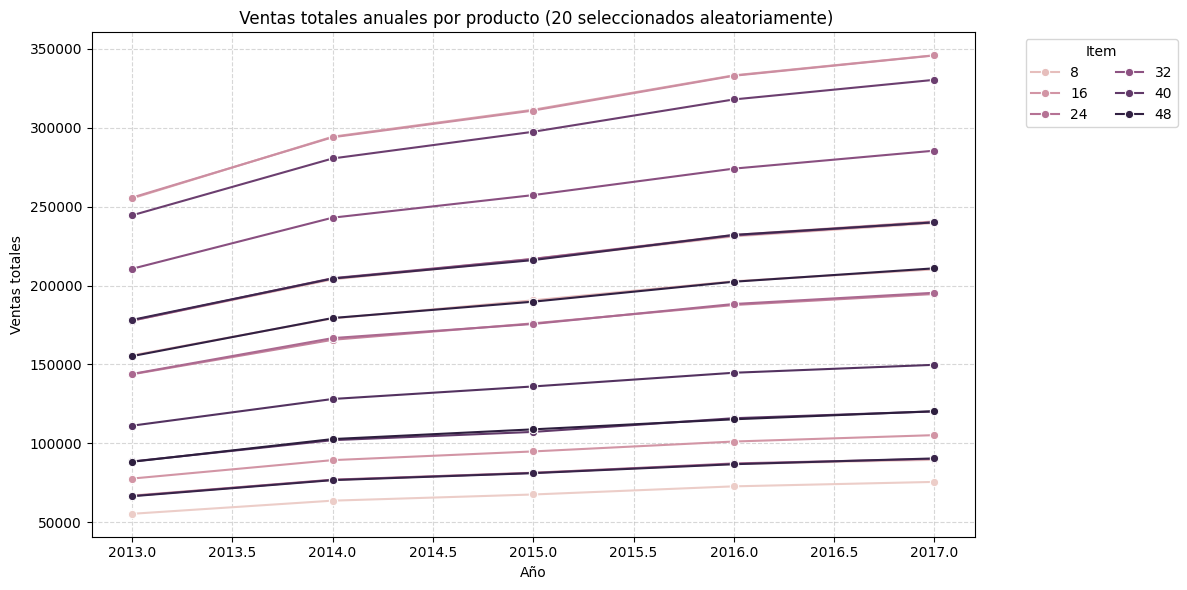

In [11]:
# Agrupar ventas totales por a√±o y producto
ventas_anuales_item = (
    data_historica
    .groupby(['year', 'item'])['sales']
    .sum()
    .reset_index()
)

# Seleccionar 20 productos aleatorios
np.random.seed(42)  # para reproducibilidad
items_random = np.random.choice(ventas_anuales_item['item'].unique(), size=20, replace=False)

# Filtrar el DataFrame a esos productos
ventas_anuales_random = ventas_anuales_item[ventas_anuales_item['item'].isin(items_random)]

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=ventas_anuales_random, x='year', y='sales', hue='item', marker='o')
plt.title(' Ventas totales anuales por producto (20 seleccionados aleatoriamente)')
plt.xlabel('A√±o')
plt.ylabel('Ventas totales')
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### üåÄ ¬øPor qu√© usar `sen` y `cos` para la semana del a√±o?

Las variables como **n√∫mero de semana (`week`)** son **c√≠clicas**: despu√©s de la semana 52 vuelve la semana 1.  
Si usamos `week` como n√∫mero lineal (1‚Ä¶52), un modelo ‚Äúcree‚Äù que 52 y 1 est√°n muy lejos, cuando en realidad son **consecutivas**.  
Para que el modelo entienda esa circularidad, mapeamos la semana a un **c√≠rculo unitario**:

\[
\text{sin\_week}=\sin\left(2\pi\cdot \frac{\text{week}}{52}\right),\quad
\text{cos\_week}=\cos\left(2\pi\cdot \frac{\text{week}}{52}\right)
\]

**Qu√© logramos:**
- Representar la **posici√≥n dentro del ciclo anual** (como un √°ngulo).
- Hacer que **semana 52 y 1 queden cercanas** en el espacio (sen‚Äìcos).
- Evitar saltos artificiales que dificultan aprender la **estacionalidad**.

**¬øPor qu√© dos columnas?**  
Con solo `sin` o solo `cos` habr√≠a ambig√ºedad (distintos √°ngulos pueden dar el mismo valor).  
Con **ambas** coordenadas el punto queda bien definido sobre el c√≠rculo.

**Notas pr√°cticas:**
- Si alg√∫n a√±o trae **semana 53**, puedes usar divisor 52.18‚âà(52+53)/2 o normalizar por el n√∫mero real de semanas de ese a√±o; lo importante es mantener la **circularidad**.
- Estas features funcionan muy bien con modelos tabulares (GBM, RF, XGBoost, etc.) y redes neuronales.

En el c√≥digo, copiamos el hist√≥rico, aseguramos que `week` sea entero y creamos `sin_week` y `cos_week`.  
El `head()` te deja verificar que las nuevas columnas est√©n calculadas correctamente.


In [12]:
# Copiar el dataset base
data_modelo = data_historica.copy()

# Asegurar que la columna 'week' est√© en formato num√©rico
data_modelo['week'] = data_modelo['week'].astype(int)

# Crear las variables c√≠clicas (semanales)
data_modelo['sin_week'] = np.sin(2 * np.pi * data_modelo['week'] / 52)
data_modelo['cos_week'] = np.cos(2 * np.pi * data_modelo['week'] / 52)

# Verificar resultado
data_modelo.head(10)


store  item       date  sales  year  week  sin_week  cos_week
0      1     1 2013-01-06     73  2013     1  0.120537  0.992709
1      1     1 2013-01-13     66  2013     2  0.239316  0.970942
2      1     1 2013-01-20     80  2013     3  0.354605  0.935016
3      1     1 2013-01-27     70  2013     4  0.464723  0.885456
4      1     1 2013-02-03     86  2013     5  0.568065  0.822984
5      1     1 2013-02-10     82  2013     6  0.663123  0.748511
6      1     1 2013-02-17     80  2013     7  0.748511  0.663123
7      1     1 2013-02-24     78  2013     8  0.822984  0.568065
8      1     1 2013-03-03     83  2013     9  0.885456  0.464723
9      1     1 2013-03-10     97  2013    10  0.935016  0.354605

In [13]:
# Verificar resultado
data_modelo.tail(10)

store  item       date  sales  year  week      sin_week  cos_week
130490     10    50 2017-10-29    539  2017    43 -8.854560e-01  0.464723
130491     10    50 2017-11-05    604  2017    44 -8.229839e-01  0.568065
130492     10    50 2017-11-12    636  2017    45 -7.485107e-01  0.663123
130493     10    50 2017-11-19    608  2017    46 -6.631227e-01  0.748511
130494     10    50 2017-11-26    583  2017    47 -5.680647e-01  0.822984
130495     10    50 2017-12-03    482  2017    48 -4.647232e-01  0.885456
130496     10    50 2017-12-10    453  2017    49 -3.546049e-01  0.935016
130497     10    50 2017-12-17    470  2017    50 -2.393157e-01  0.970942
130498     10    50 2017-12-24    442  2017    51 -1.205367e-01  0.992709
130499     10    50 2017-12-31    432  2017    52  6.432491e-16  1.000000

###  Creaci√≥n de variables de rezago y ventanas m√≥viles

En esta celda se generan las **caracter√≠sticas temporales** que permiten a los modelos de Machine Learning capturar la **dependencia temporal** y la **tendencia de las ventas** en el tiempo:

1. **Orden temporal:**  
   Se ordenan los datos por `store`, `item` y `date` para garantizar la secuencia cronol√≥gica correcta dentro de cada serie individual (tienda‚Äìproducto).

2. **Variables de rezago (`lag`):**  
   Con `shift(lag)` se crean columnas que contienen las ventas de semanas anteriores (1, 2, 4, 8 y 12).  
   Estas variables permiten al modelo aprender patrones de **autocorrelaci√≥n**, es decir, c√≥mo las ventas pasadas influyen en las futuras.

3. **Ventanas m√≥viles (`rolling`):**  
   Se calculan el **promedio** y la **desviaci√≥n est√°ndar** de las ventas en las √∫ltimas 4 y 8 semanas usando `rolling(window)`.  
   Esto ayuda a representar **tendencias recientes** y **variabilidad** del comportamiento del producto.

4. **Prevenci√≥n de fuga de informaci√≥n:**  
   Se aplica `shift(1)` antes del c√°lculo de las ventanas para asegurarse de que solo se utilicen datos **anteriores** a la semana actual (nunca del futuro).

5. **Limpieza final:**  
   Se eliminan las filas con `NaN`, generadas en las primeras semanas donde no existen suficientes observaciones previas para calcular los rezagos o promedios.

En conjunto, estas transformaciones enriquecen la serie temporal con informaci√≥n contextual, haciendo posible que el modelo capture **tendencias, estacionalidad y persistencia temporal** en las ventas.


In [14]:
# --- Crear variables de rezago y ventanas m√≥viles ---

# Ordenar correctamente
data_modelo = data_modelo.sort_values(['store', 'item', 'date'])

#  Lags de 1, 2, 4, 8 y 12 semanas
for lag in [1, 2, 4, 8, 12]:
    data_modelo[f'sales_lag_{lag}'] = (
        data_modelo.groupby(['store', 'item'])['sales']
        .shift(lag)
    )

#  Ventanas m√≥viles de 4 y 8 semanas (usando transform en lugar de reset_index)
for window in [4, 8]:
    data_modelo[f'rolling_mean_{window}'] = (
        data_modelo.groupby(['store', 'item'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window).mean())
    )
    
    data_modelo[f'rolling_std_{window}'] = (
        data_modelo.groupby(['store', 'item'])['sales']
        .transform(lambda x: x.shift(1).rolling(window=window).std())
    )

#  Eliminar filas con NaN generadas por los rezagos iniciales
data_modelo = data_modelo.dropna().reset_index(drop=True)

#  Revisar estructura final
print(data_modelo.shape)
data_modelo.head()



(124500, 17)


store  item       date  sales  year  week  sin_week      cos_week  \
0      1     1 2013-03-31    109  2013    13  1.000000 -1.608123e-16   
1      1     1 2013-04-07    131  2013    14  0.992709 -1.205367e-01   
2      1     1 2013-04-14    128  2013    15  0.970942 -2.393157e-01   
3      1     1 2013-04-21    125  2013    16  0.935016 -3.546049e-01   
4      1     1 2013-04-28    112  2013    17  0.885456 -4.647232e-01   

   sales_lag_1  sales_lag_2  sales_lag_4  sales_lag_8  sales_lag_12  \
0        122.0        101.0         83.0         86.0          73.0   
1        109.0        122.0         97.0         82.0          66.0   
2        131.0        109.0        101.0         80.0          80.0   
3        128.0        131.0        122.0         78.0          70.0   
4        125.0        128.0        109.0         83.0          86.0   

   rolling_mean_4  rolling_std_4  rolling_mean_8  rolling_std_8  
0          100.75      16.132266          91.125      14.913441  
1          107.25      11.026483          94.000      15.964246  
2          115.75      13.351030         100.125      19.671862  
3          122.50       9.746794         106.125      19.974537  
4          123.25       9.810708         112.000      17.246118

In [15]:
data_modelo = data_modelo.drop(columns=["date"])

In [16]:
data_modelo.head()

store  item  sales  year  week  sin_week      cos_week  sales_lag_1  \
0      1     1    109  2013    13  1.000000 -1.608123e-16        122.0   
1      1     1    131  2013    14  0.992709 -1.205367e-01        109.0   
2      1     1    128  2013    15  0.970942 -2.393157e-01        131.0   
3      1     1    125  2013    16  0.935016 -3.546049e-01        128.0   
4      1     1    112  2013    17  0.885456 -4.647232e-01        125.0   

   sales_lag_2  sales_lag_4  sales_lag_8  sales_lag_12  rolling_mean_4  \
0        101.0         83.0         86.0          73.0          100.75   
1        122.0         97.0         82.0          66.0          107.25   
2        109.0        101.0         80.0          80.0          115.75   
3        131.0        122.0         78.0          70.0          122.50   
4        128.0        109.0         83.0          86.0          123.25   

   rolling_std_4  rolling_mean_8  rolling_std_8  
0      16.132266          91.125      14.913441  
1      11.026483          94.000      15.964246  
2      13.351030         100.125      19.671862  
3       9.746794         106.125      19.974537  
4       9.810708         112.000      17.246118

### ‚è≥ Por qu√© dividir los datos por a√±o y no con `train_test_split`

En problemas de **series temporales**, como el pron√≥stico de demanda, el tiempo tiene una **direcci√≥n natural**: el modelo aprende del pasado para predecir el futuro.  
Por eso, no podemos dividir los datos de forma aleatoria (como hace `train_test_split` de scikit-learn), ya que eso mezclar√≠a semanas pasadas y futuras en los conjuntos de entrenamiento y prueba.

En lugar de eso, la divisi√≥n se hace **respetando la secuencia temporal**:
- `train`: incluye todas las observaciones **anteriores a 2017**, que representan el historial de ventas.  
- `test`: contiene los datos de **2017**, que simulan el "futuro" que el modelo debe predecir.

Este enfoque:
- Evita **fugas de informaci√≥n**, ya que el modelo nunca ve datos de fechas posteriores durante el entrenamiento.  
- Permite evaluar el rendimiento en un escenario **realista de forecasting**, donde solo disponemos del pasado.  
- Garantiza que los patrones aprendidos reflejen **causalidad temporal** (lo que pasa antes influye en lo que viene despu√©s).


In [17]:
# ===============================================
#  Divisi√≥n temporal y definici√≥n de variables
# ===============================================

# Separar los datos por a√±o:
# Entrenamiento: todo antes de 2017
# Prueba: solo el a√±o 2017 (√∫ltimo a√±o hist√≥rico)
train = data_modelo[data_modelo['year'] < 2017].copy()
test = data_modelo[data_modelo['year'] == 2017].copy()

# Definir las variables predictoras (features)
# Incluyen informaci√≥n temporal, rezagos y estad√≠sticas m√≥viles
features = [
    'store', 'item', 'year', 'week', 
    'sin_week', 'cos_week',                # variables c√≠clicas (estacionalidad)
    'sales_lag_1', 'sales_lag_2', 'sales_lag_4',   # rezagos (memoria temporal)
    'sales_lag_8', 'sales_lag_12',
    'rolling_mean_4', 'rolling_std_4',     # medias y desviaciones m√≥viles
    'rolling_mean_8', 'rolling_std_8'
]

# Variable objetivo: la demanda semanal (ventas)
target = 'sales'

# Dividir en conjuntos de entrenamiento y prueba
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Mostrar dimensiones de los datasets generados
print("===== üßæ Dimensiones de los datasets =====")
print(f"data_modelo: {data_modelo.shape}")  # dataset completo
print(f"train:       {train.shape}")        # conjunto de entrenamiento
print(f"test:        {test.shape}")         # conjunto de prueba
print(f"X_train:     {X_train.shape}")      # variables predictoras (train)
print(f"y_train:     {y_train.shape}")      # variable objetivo (train)
print(f"X_test:      {X_test.shape}")       # variables predictoras (test)
print(f"y_test:      {y_test.shape}")       # variable objetivo (test)


===== üßæ Dimensiones de los datasets =====
data_modelo: (124500, 16)
train:       (98500, 16)
test:        (26000, 16)
X_train:     (98500, 15)
y_train:     (98500,)
X_test:      (26000, 15)
y_test:      (26000,)


###  Comparaci√≥n de modelos de regresi√≥n

En esta celda se comparan diferentes algoritmos de regresi√≥n para determinar cu√°l predice mejor la demanda.  
El objetivo es evaluar el rendimiento de modelos con distintos enfoques (lineal, basado en √°rboles y ensambles) sobre el mismo conjunto de datos.

**1Ô∏è Modelos evaluados:**
- **Linear Regression:** modelo base que asume relaciones lineales entre las variables.  
- **Random Forest:** conjunto de √°rboles independientes que mejora la precisi√≥n al reducir el sobreajuste.  
- **Gradient Boosting:** modelo secuencial donde cada √°rbol corrige los errores del anterior.  
- **XGBoost:** versi√≥n optimizada del boosting, eficiente y con excelente rendimiento en datos tabulares.

**2Ô∏è M√©tricas utilizadas:**
- **RMSE (Root Mean Squared Error):** mide el error promedio en las predicciones; valores menores indican mayor precisi√≥n.  
- **R¬≤ (Coeficiente de determinaci√≥n):** mide qu√© proporci√≥n de la variabilidad de las ventas es explicada por el modelo.

**3Ô∏è Flujo del proceso:**
- Se entrena cada modelo con los mismos datos (`X_train`, `y_train`).  
- Se eval√∫a su desempe√±o sobre el conjunto de prueba (`X_test`, `y_test`).  
- Los resultados se organizan en un DataFrame y se visualizan con un gr√°fico de barras, donde un **RMSE menor** representa mejor desempe√±o.


In [18]:
# =====================================
# üöÄ Comparaci√≥n de modelos de regresi√≥n
# =====================================

# --- 3Ô∏è Definir modelos a comparar ---
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42, tree_method='hist'),
}

# --- 4Ô∏è Entrenar y evaluar ---
resultados = []

for nombre, modelo in modelos.items():
    print(f"‚öôÔ∏è Entrenando {nombre}...")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({"Modelo": nombre, "RMSE": rmse, "R¬≤": r2})


‚öôÔ∏è Entrenando Linear Regression...
‚öôÔ∏è Entrenando Random Forest...
‚öôÔ∏è Entrenando Gradient Boosting...
‚öôÔ∏è Entrenando XGBoost...



üìä Resultados comparativos:

              Modelo       RMSE        R¬≤
2  Gradient Boosting  23.054366  0.987613
3            XGBoost  23.186263  0.987471
1      Random Forest  25.318052  0.985061
0  Linear Regression  32.919898  0.974744


C:\Users\jlvar\AppData\Local\Temp\ipykernel_28084\4248437437.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x="RMSE", y="Modelo", palette="viridis")


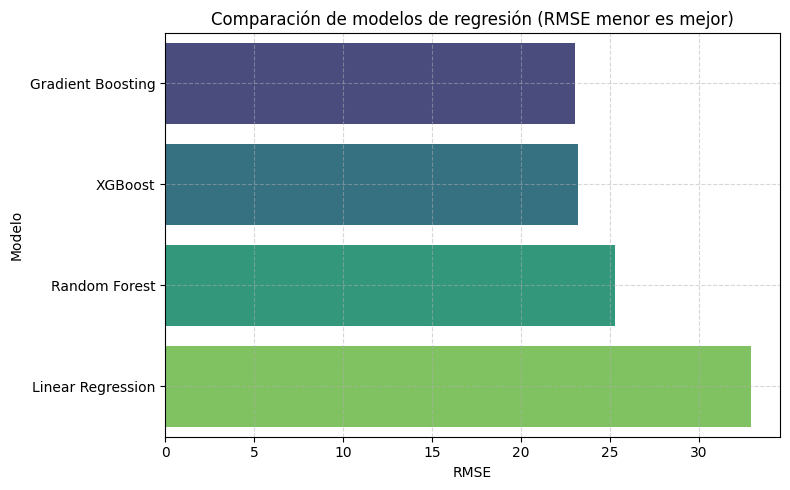

In [19]:
# ---  Mostrar resultados ---
df_resultados = pd.DataFrame(resultados).sort_values("RMSE")
print("\nüìä Resultados comparativos:\n")
print(df_resultados)

# ---  Visualizar comparativa ---
plt.figure(figsize=(8,5))
sns.barplot(data=df_resultados, x="RMSE", y="Modelo", palette="viridis")
plt.title("Comparaci√≥n de modelos de regresi√≥n (RMSE menor es mejor)")
plt.xlabel("RMSE")
plt.ylabel("Modelo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:


# ===========================================================
# üîπ 1. CREACI√ìN DEL MODELO BASE
# ===========================================================
# Gradient Boosting es un modelo de ensamble que construye una secuencia
# de √°rboles de decisi√≥n, donde cada nuevo √°rbol intenta corregir los errores
# del conjunto anterior. Es muy potente para problemas de regresi√≥n.
gbr = GradientBoostingRegressor(random_state=42)

# ===========================================================
# üîπ 2. DEFINICI√ìN DE LA REJILLA DE HIPERPAR√ÅMETROS
# ===========================================================
# En este diccionario se definen los valores que el Grid Search probar√°
# en distintas combinaciones. Cada hiperpar√°metro afecta de forma distinta
# la complejidad y el rendimiento del modelo:

param_grid = {
    'n_estimators': [ 200, 300, 400],
    # N√∫mero de √°rboles en el ensamble.
    # Aumentarlo suele mejorar la precisi√≥n hasta cierto punto,
    # pero tambi√©n incrementa el tiempo de entrenamiento y el riesgo de sobreajuste.

    'learning_rate': [0.01, 0.05, 0.1],
    # Tasa de aprendizaje: controla cu√°nto contribuye cada √°rbol nuevo
    # al modelo final. Valores m√°s peque√±os (como 0.01 o 0.05)
    # hacen el modelo m√°s estable pero requieren m√°s √°rboles (n_estimators altos).

    'max_depth': [3, 4, 5, 6],
    # Profundidad m√°xima de cada √°rbol. Cuanto m√°s profundo, m√°s complejas
    # son las reglas que aprende el modelo. Profundidades altas pueden
    # capturar relaciones no lineales, pero tambi√©n aumentar el riesgo de sobreajuste.
}

# ===========================================================
# üîπ 3. CONFIGURACI√ìN DEL GRID SEARCH
# ===========================================================
# GridSearchCV probar√° todas las combinaciones posibles de los par√°metros
# definidos en `param_grid`. Usa validaci√≥n cruzada para evaluar
# el rendimiento medio de cada combinaci√≥n.

grid_search = GridSearchCV(
    estimator=gbr,                   # modelo base a optimizar
    param_grid=param_grid,           # conjunto de valores a probar
    cv=5,                            # n√∫mero de divisiones para validaci√≥n cruzada
    scoring=make_scorer(r2_score),   # m√©trica de evaluaci√≥n: R¬≤ (mayor es mejor)
    n_jobs=-1,                       # utiliza todos los n√∫cleos disponibles para acelerar
    verbose=2                        # muestra el progreso en consola
)

# ===========================================================
# üîπ 4. ENTRENAMIENTO DEL GRID SEARCH
# ===========================================================
# Este paso entrena m√∫ltiples modelos (uno por combinaci√≥n de hiperpar√°metros)
# y selecciona autom√°ticamente el que obtiene el mejor R¬≤ promedio.
grid_search.fit(X_train, y_train)

# ===========================================================
# üîπ 5. RESULTADOS DE LA B√öSQUEDA
# ===========================================================
print("‚úÖ Mejor combinaci√≥n de hiperpar√°metros:")
print(grid_search.best_params_)

print("\nüìà Mejor R¬≤ (validaci√≥n cruzada):")
print(round(grid_search.best_score_, 4))

# ===========================================================
# üîπ 6. EVALUACI√ìN FINAL DEL MODELO √ìPTIMO
# ===========================================================
# Una vez encontrado el mejor conjunto de hiperpar√°metros,
# se entrena el modelo con ellos y se eval√∫a sobre el conjunto de prueba.
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nüéØ R¬≤ en conjunto de prueba:", round(r2_score(y_test, y_pred), 4))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

###  Creaci√≥n del conjunto base para el pron√≥stico 2018

En esta celda se construye la estructura que servir√° como **base temporal** para realizar las predicciones del a√±o 2018.  
El objetivo es generar todas las combinaciones posibles de **tienda (`store`)**, **producto (`item`)** y **semana del a√±o (`week`)**, asegurando que cada par tienda‚Äìproducto tenga una fila para cada semana del a√±o.

1. **Listas √∫nicas de tiendas y productos:**  
   Se extraen los valores √∫nicos del hist√≥rico (`data_modelo`) para conocer todas las tiendas y productos disponibles.

2. **Combinaciones tienda‚Äìproducto:**  
   Con `pd.MultiIndex.from_product()` se genera la tabla con todas las combinaciones posibles entre tiendas y productos, asegurando que ninguna quede por fuera.

3. **Semanas del a√±o 2018:**  
   Se crea un DataFrame con las semanas del 1 al 52 y el a√±o correspondiente.

4. **Cruce cartesiano:**  
   Se combinan las dos tablas (tienda‚Äìproducto y semanas) mediante una clave auxiliar (`key=1`), generando as√≠ **una fila por cada semana del 2018 para cada tienda y producto**.

5. **Orden y limpieza:**  
   Se organizan las columnas y se reinicia el √≠ndice para dejar el dataset limpio y ordenado.

El resultado es un DataFrame con la **estructura temporal completa de 2018**, lista para a√±adir variables adicionales (como `sin_week`, `cos_week` y predicciones de ventas).


In [ ]:


# 1Ô∏è Obtener listas √∫nicas de tiendas y productos del hist√≥rico
stores = data_modelo['store'].unique()
items = data_modelo['item'].unique()

# 2Ô∏è Crear todas las combinaciones tienda-producto
base = pd.MultiIndex.from_product([stores, items], names=['store', 'item']).to_frame(index=False)

# 3Ô∏è Crear las 52 semanas del a√±o 2018
weeks_2018 = pd.DataFrame({'week': np.arange(1, 53), 'year': 2018})

# 4Ô∏è Combinar para obtener todas las combinaciones posibles
data_2018 = base.assign(key=1).merge(weeks_2018.assign(key=1), on='key').drop(columns='key')

# 5Ô∏è Ordenar columnas y revisar
data_2018 = data_2018[['store', 'item', 'year', 'week']].sort_values(['store', 'item', 'week']).reset_index(drop=True)

#  Resultado
print(f" Filas totales: {data_2018.shape[0]}")
data_2018.head(10)


üî¢ Filas totales: 26000


store  item  year  week
0      1     1  2018     1
1      1     1  2018     2
2      1     1  2018     3
3      1     1  2018     4
4      1     1  2018     5
5      1     1  2018     6
6      1     1  2018     7
7      1     1  2018     8
8      1     1  2018     9
9      1     1  2018    10

In [ ]:
# A√±adir variables c√≠clicas de la semana
data_2018['sin_week'] = np.sin(2 * np.pi * data_2018['week'] / 52)
data_2018['cos_week'] = np.cos(2 * np.pi * data_2018['week'] / 52)

# Ver resultado
data_2018.head(10)


store  item  year  week  sin_week  cos_week
0      1     1  2018     1  0.120537  0.992709
1      1     1  2018     2  0.239316  0.970942
2      1     1  2018     3  0.354605  0.935016
3      1     1  2018     4  0.464723  0.885456
4      1     1  2018     5  0.568065  0.822984
5      1     1  2018     6  0.663123  0.748511
6      1     1  2018     7  0.748511  0.663123
7      1     1  2018     8  0.822984  0.568065
8      1     1  2018     9  0.885456  0.464723
9      1     1  2018    10  0.935016  0.354605

###  Integraci√≥n del hist√≥rico con el calendario de predicci√≥n

En esta celda se combina el **hist√≥rico de ventas** (`data_modelo`) con el **conjunto base de 2018** (`data_2018`) para crear un √∫nico DataFrame continuo llamado `data_full`.

1. **Copia del hist√≥rico:**  
   Se realiza una copia del dataset original para evitar modificar los datos base.

2. **Preparaci√≥n del dataset futuro:**  
   En `data_2018` se a√±ade la columna `sales` con valores `NaN`, ya que las ventas de 2018 a√∫n no son conocidas y ser√°n las que el modelo deber√° predecir.

3. **Uni√≥n de hist√≥rico y futuro:**  
   Se usa `pd.concat()` para unir ambos conjuntos, manteniendo todas las filas y columnas.  
   Esto permite que las semanas de 2018 queden alineadas cronol√≥gicamente despu√©s del hist√≥rico (hasta 2017).

4. **Ordenamiento temporal:**  
   Se ordenan los registros por `store`, `item`, `year` y `week`, garantizando que las observaciones sigan el orden correcto dentro de cada serie temporal.

El resultado, `data_full`, contiene tanto los datos reales del pasado como las semanas futuras a predecir, formando la base para el **proceso de forecasting recursivo**.


In [ ]:
# Copiar el hist√≥rico
data_full = data_modelo.copy()

# Agregar el dataset de 2018 (sin ventas todav√≠a)
data_2018['sales'] = np.nan  # placeholder
data_full = pd.concat([data_full, data_2018], ignore_index=True)
data_full = data_full.sort_values(['store', 'item', 'year', 'week']).reset_index(drop=True)

print(f" Total filas combinadas: {data_full.shape[0]}")
data_full.tail(10)


üìä Total filas combinadas: 150500


store  item  sales  year  week      sin_week  cos_week  sales_lag_1  \
150490     10    50    NaN  2018    43 -8.854560e-01  0.464723          NaN   
150491     10    50    NaN  2018    44 -8.229839e-01  0.568065          NaN   
150492     10    50    NaN  2018    45 -7.485107e-01  0.663123          NaN   
150493     10    50    NaN  2018    46 -6.631227e-01  0.748511          NaN   
150494     10    50    NaN  2018    47 -5.680647e-01  0.822984          NaN   
150495     10    50    NaN  2018    48 -4.647232e-01  0.885456          NaN   
150496     10    50    NaN  2018    49 -3.546049e-01  0.935016          NaN   
150497     10    50    NaN  2018    50 -2.393157e-01  0.970942          NaN   
150498     10    50    NaN  2018    51 -1.205367e-01  0.992709          NaN   
150499     10    50    NaN  2018    52  6.432491e-16  1.000000          NaN   

        sales_lag_2  sales_lag_4  sales_lag_8  sales_lag_12  rolling_mean_4  \
150490          NaN          NaN          NaN           NaN             NaN   
150491          NaN          NaN          NaN           NaN             NaN   
150492          NaN          NaN          NaN           NaN             NaN   
150493          NaN          NaN          NaN           NaN             NaN   
150494          NaN          NaN          NaN           NaN             NaN   
150495          NaN          NaN          NaN           NaN             NaN   
150496          NaN          NaN          NaN           NaN             NaN   
150497          NaN          NaN          NaN           NaN             NaN   
150498          NaN          NaN          NaN           NaN             NaN   
150499          NaN          NaN          NaN           NaN             NaN   

        rolling_std_4  rolling_mean_8  rolling_std_8  
150490            NaN             NaN            NaN  
150491            NaN             NaN            NaN  
150492            NaN             NaN            NaN  
150493            NaN             NaN            NaN  
150494            NaN             NaN            NaN  
150495            NaN             NaN            NaN  
150496            NaN             NaN            NaN  
150497            NaN             NaN            NaN  
150498            NaN             NaN            NaN  
150499            NaN             NaN            NaN

### Funci√≥n `actualizar_lags_y_rollings()`

Esta funci√≥n permite **recalcular din√°micamente** las variables de **rezago (lag)** y **ventanas m√≥viles (rolling)** dentro de cada grupo de tienda y producto (`store`, `item`).  
Es fundamental para el proceso de **predicci√≥n recursiva**, donde las nuevas ventas pronosticadas se incorporan semana a semana y los lags deben actualizarse tras cada predicci√≥n.

**Explicaci√≥n paso a paso:**

1. **Ordenamiento temporal:**  
   Se ordenan los registros por `store`, `item`, `year` y `week` para asegurar que las operaciones se realicen en el orden cronol√≥gico correcto dentro de cada serie.

2. **C√°lculo de rezagos (`lag`):**  
   Con `shift(lag)` se generan columnas que contienen las ventas de semanas anteriores (1, 2, 4, 8 y 12).  
   Esto permite al modelo conocer el comportamiento pasado m√°s reciente de cada tienda y producto.

3. **C√°lculo de ventanas m√≥viles (`rolling`):**  
   Para cada grupo, se calcula la **media** y la **desviaci√≥n est√°ndar** de las ventas en las √∫ltimas 4 y 8 semanas, usando `transform()` para mantener la estructura del DataFrame.  
   El `shift(1)` evita usar informaci√≥n de la semana actual (previene fuga de informaci√≥n).

4. **Retorno actualizado:**  
   Devuelve el DataFrame con todas las variables de rezago y tendencia actualizadas, listo para usar en la siguiente iteraci√≥n de predicci√≥n.

Esta funci√≥n mantiene la coherencia temporal del dataset durante el forecasting, asegurando que las nuevas predicciones alimenten correctamente los indicadores hist√≥ricos.


In [ ]:
def actualizar_lags_y_rollings(df):
    """
    Recalcula variables de rezago (lags) y ventanas m√≥viles (rolling means/stds)
    dentro de cada combinaci√≥n de tienda y producto.

    Esta funci√≥n es clave para modelos de pron√≥stico de series de tiempo
    donde las ventas futuras dependen de valores pasados recientes.

    Par√°metros
    ----------
    df : pandas.DataFrame
        DataFrame con las columnas:
        - 'store' : identificador de tienda
        - 'item'  : identificador de producto
        - 'year' y 'week' : definen la secuencia temporal
        - 'sales' : variable objetivo (ventas)

    Retorna
    -------
    df : pandas.DataFrame
        Mismo DataFrame con nuevas columnas:
        - 'sales_lag_1', 'sales_lag_2', 'sales_lag_4', 'sales_lag_8', 'sales_lag_12'
          ‚Üí valores de ventas en semanas anteriores.
        - 'rolling_mean_4', 'rolling_mean_8'
          ‚Üí promedio m√≥vil de las √∫ltimas 4 u 8 semanas.
        - 'rolling_std_4', 'rolling_std_8'
          ‚Üí desviaci√≥n est√°ndar m√≥vil de las √∫ltimas 4 u 8 semanas.
    """

    # Ordenar el DataFrame por claves de agrupaci√≥n y tiempo
    df = df.sort_values(['store', 'item', 'year', 'week'])

    # --- 1Ô∏è Calcular variables de rezago ---
    # Para cada grupo (tienda, producto), desplaza las ventas 'n' semanas hacia atr√°s
    for lag in [1, 2, 4, 8, 12]:
        df[f'sales_lag_{lag}'] = (
            df.groupby(['store', 'item'])['sales'].shift(lag)
        )

    # --- 2Ô∏è Calcular variables de ventanas m√≥viles ---
    # Para cada grupo, calcula el promedio y desviaci√≥n est√°ndar de las √∫ltimas semanas
    for window in [4, 8]:
        # Promedio m√≥vil (rolling mean) con desplazamiento previo
        df[f'rolling_mean_{window}'] = (
            df.groupby(['store', 'item'])['sales']
            .transform(lambda x: x.shift(1).rolling(window).mean())
        )
        # Desviaci√≥n est√°ndar m√≥vil (rolling std) con desplazamiento previo
        df[f'rolling_std_{window}'] = (
            df.groupby(['store', 'item'])['sales']
            .transform(lambda x: x.shift(1).rolling(window).std())
        )

    return df



In [ ]:
data_full = actualizar_lags_y_rollings(data_full)
# Confirmar que los primeros lags de 2018 (semana 1) est√°n poblados
data_full[(data_full['year'] == 2018) & (data_full['week'] == 1)].head()

store  item  sales  year  week  sin_week  cos_week  sales_lag_1  \
249       1     1    NaN  2018     1  0.120537  0.992709        127.0   
550       1     2    NaN  2018     1  0.120537  0.992709        358.0   
851       1     3    NaN  2018     1  0.120537  0.992709        185.0   
1152      1     4    NaN  2018     1  0.120537  0.992709        121.0   
1453      1     5    NaN  2018     1  0.120537  0.992709         99.0   

      sales_lag_2  sales_lag_4  sales_lag_8  sales_lag_12  rolling_mean_4  \
249          97.0        126.0        145.0         147.0          116.75   
550         292.0        319.0        460.0         382.0          324.00   
851         177.0        209.0        263.0         245.0          194.50   
1152        110.0        108.0        177.0         171.0          110.75   
1453         84.0         92.0        131.0         117.0           96.50   

      rolling_std_4  rolling_mean_8  rolling_std_8  
249       13.913423         136.125      26.172164  
550       27.166155         386.250      69.151490  
851       15.947832         225.375      37.140419  
1152       7.274384         136.875      31.579548  
1453      11.445523         114.750      23.057382

In [ ]:
# =====================================
#  Entrenar Gradient Boosting Regressor
# =====================================

# --- 1Ô∏è Definir las columnas de entrada ---
features = [
    'store', 'item', 'year', 'week',
    'sin_week', 'cos_week',
    'sales_lag_1', 'sales_lag_2', 'sales_lag_4',
    'sales_lag_8', 'sales_lag_12',
    'rolling_mean_4', 'rolling_std_4',
    'rolling_mean_8', 'rolling_std_8'
]
target = 'sales'

# --- 2Ô∏è Usar solo datos con ventas reales (hasta 2017) ---
train = data_full[data_full['year'] <= 2017].dropna(subset=['sales'])
train = train.fillna(0).reset_index(drop=True)
X_train, y_train = train[features], train[target]

print("===== üßæ Dimensiones del conjunto de entrenamiento =====")
print(f"X_train shape: {X_train.shape}")  # filas y columnas de features
print(f"y_train shape: {y_train.shape}")  # solo filas (target)

print("\n===== üîç Verificaci√≥n r√°pida =====")
print(f"N√∫mero de observaciones: {len(X_train)}")
print(f"N√∫mero de variables (features): {X_train.shape[1]}")



In [ ]:
print("‚öôÔ∏è Entrenando modelo Gradient Boosting...")
best_model.fit(X_train, y_train)
print(" Entrenamiento completado.")

# --- 4Ô∏è Evaluar rendimiento sobre el hist√≥rico ---
y_pred_train = best_model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred_train, squared=False)
r2 = r2_score(y_train, y_pred_train)

print(f"\nüìä Rendimiento en entrenamiento:")
print(f"RMSE: {rmse:.2f}")
print(f"R¬≤: {r2:.3f}")


In [ ]:
import joblib
joblib.dump(best_model, "gradient_boosting_model.pkl")


In [ ]:
gb_model = joblib.load("gradient_boosting_model.pkl")

###  Predicci√≥n recursiva semana a semana (forecast 2018)

En esta celda se realiza la **predicci√≥n autom√°tica de las ventas para el a√±o 2018**, avanzando semana a semana y actualizando los valores calculados en cada paso.  
Este enfoque se conoce como **forecasting recursivo**, y permite extender las predicciones hacia el futuro sin disponer de datos reales de ventas.

**1Ô∏è Definici√≥n de las variables de entrada:**  
Se asegura que las columnas (`features`) usadas en la predicci√≥n sean exactamente las mismas que se utilizaron durante el entrenamiento del modelo (`gb_model`).

**2Ô∏è Actualizaci√≥n inicial de rezagos:**  
Antes de empezar el pron√≥stico, se llama a la funci√≥n `actualizar_lags_y_rollings()` para calcular los rezagos y promedios m√≥viles con los datos hist√≥ricos m√°s recientes (hasta 2017).

**3Ô∏è Predicci√≥n recursiva:**  
El bucle `for week in tqdm(range(1, 53))` recorre las 52 semanas del a√±o 2018:
- Se filtran las filas de la semana actual sin valor de ventas (`sales` = NaN).  
- Se genera la predicci√≥n (`y_pred`) usando el modelo entrenado.  
- Los valores pronosticados se insertan en `data_full`.  
- Finalmente, se **recalcula** la informaci√≥n de `lag` y `rolling` para que las predicciones reci√©n generadas se utilicen en la siguiente semana.



Este bloque simula el comportamiento real de un sistema de pron√≥stico operativo:  
cada semana se predice la demanda, se actualizan las variables con esa informaci√≥n y el modelo contin√∫a aprendiendo del ‚Äúpasado‚Äù m√°s reciente.


In [ ]:
# ===============================================
#  Predicci√≥n recursiva de la demanda para 2018
# ===============================================

# tqdm permite mostrar una barra de progreso visual durante el bucle
from tqdm import tqdm

# --- 1Ô∏è Definir las variables predictoras ---
# Estas deben ser exactamente las mismas usadas en el entrenamiento del modelo
features = [
    'store', 'item', 'year', 'week', 
    'sin_week', 'cos_week',                   # variables c√≠clicas (representan el patr√≥n semanal)
    'sales_lag_1', 'sales_lag_2', 'sales_lag_4',  # rezagos (memoria del pasado)
    'sales_lag_8', 'sales_lag_12',
    'rolling_mean_4', 'rolling_std_4',        # medias y desviaciones m√≥viles (tendencias locales)
    'rolling_mean_8', 'rolling_std_8'
]

# --- 2Ô∏è Recalcular los lags antes de iniciar ---
# Se asegura que las variables de rezago y rolling est√©n actualizadas
# con la √∫ltima informaci√≥n del hist√≥rico antes de iniciar la predicci√≥n
data_full = actualizar_lags_y_rollings(data_full)

# --- 3Ô∏è Proceso de predicci√≥n recursiva ---
# Se realiza la predicci√≥n semana a semana (1 a 52) para todo el a√±o 2018
for week in tqdm(range(1, 53)):  # tqdm agrega una barra de progreso visual
    
    # Filtro: filas correspondientes a la semana actual de 2018 que a√∫n no tienen predicci√≥n
    mask = (
        (data_full['year'] == 2018) &
        (data_full['week'] == week) &
        (data_full['sales'].isna())
    )
    
    # Extraer las caracter√≠sticas para esa semana
    X_pred = data_full.loc[mask, features]
    
    # Si existen filas para predecir (evita errores con semanas vac√≠as)
    if not X_pred.empty:
        # üîπ Generar predicciones con el modelo entrenado (Gradient Boosting)
        y_pred = gb_model.predict(X_pred)
        
        # üîπ Asignar las predicciones al dataset principal
        data_full.loc[mask, 'sales'] = y_pred

        # üîπ Recalcular los rezagos y promedios m√≥viles
        # Esto permite que las nuevas predicciones alimenten las variables de las semanas siguientes
        data_full = actualizar_lags_y_rollings(data_full)

#  Al finalizar, 'data_full' contendr√° las predicciones para las 52 semanas del a√±o 2018

In [ ]:
# --- 1Ô∏è Agrupar las ventas semanales totales ---
ventas_semanales = (
    data_full
    .groupby(['year', 'week'])['sales']
    .sum()
    .reset_index()
    .sort_values(['year', 'week'])
)

# --- 2Ô∏è Separar hist√≥rico (<=2017) y pron√≥stico (2018) ---
historico = ventas_semanales[ventas_semanales['year'] <= 2017]
forecast  = ventas_semanales[ventas_semanales['year'] == 2018]

# --- 3Ô∏è Graficar ---
plt.figure(figsize=(14,6))

# Hist√≥rico en azul
plt.plot(historico['year'] + historico['week']/52,
         historico['sales'],
         color='steelblue', marker='o', label='Hist√≥rico (2013‚Äì2017)')

# Pron√≥stico en rojo
plt.plot(forecast['year'] + forecast['week']/52,
         forecast['sales'],
         color='red', marker='o', label='Pron√≥stico 2018')

plt.title("üìä Total de ventas semanales (Hist√≥rico vs Pron√≥stico 2018)", fontsize=13)
plt.xlabel("A√±o")
plt.ylabel("Ventas totales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, Dropdown

# --- Preparar el DataFrame base ---
# Agrupar por semana, tienda e item
ventas_interact = (
    data_full
    .groupby(['store', 'item', 'year', 'week'])['sales']
    .sum()
    .reset_index()
    .sort_values(['store', 'item', 'year', 'week'])
)

# --- Obtener valores √∫nicos ---
stores = sorted(ventas_interact['store'].unique())
items = sorted(ventas_interact['item'].unique())

# --- Funci√≥n para actualizar el gr√°fico ---
def plot_forecast(store, item):
    df = ventas_interact[(ventas_interact['store'] == store) & (ventas_interact['item'] == item)]

    if df.empty:
        print("‚ö†Ô∏è No hay datos para esta combinaci√≥n.")
        return

    hist = df[df['year'] <= 2017]
    pred = df[df['year'] == 2018]

    fig = go.Figure()

    # Hist√≥rico
    fig.add_trace(go.Scatter(
        x=hist['year'] + hist['week']/52,
        y=hist['sales'],
        mode='lines+markers',
        name='Hist√≥rico (2013‚Äì2017)',
        line=dict(color='steelblue')
    ))

    # Pron√≥stico 2018
    fig.add_trace(go.Scatter(
        x=pred['year'] + pred['week']/52,
        y=pred['sales'],
        mode='lines+markers',
        name='Pron√≥stico 2018',
        line=dict(color='red')
    ))

    fig.update_layout(
        title=f"üìä Pron√≥stico semanal 2018 ‚Äî Store {store} | Item {item}",
        xaxis_title="A√±o",
        yaxis_title="Ventas totales",
        template="plotly_white",
        hovermode="x unified",
        legend=dict(x=0.02, y=0.98, bordercolor="gray", borderwidth=0.5)
    )
    fig.show()

# --- Crear controles interactivos ---
interact(
    plot_forecast,
    store=Dropdown(options=stores, description="üè™ Tienda:"),
    item=Dropdown(options=items, description="üì¶ Producto:")
)
